In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
from pathlib import Path
sns.set_style('whitegrid')  # Set whitegrid style from Seaborn
#import mplfinance as mpf
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import plotly.express as px
import matplotlib.ticker as tkr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

from collections import defaultdict

from scipy import stats

from datetime import datetime
import pytz

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [3]:
import pandas as pd

# Load the datasets
actuals = pd.read_csv('GR price actuals.csv')
provider1 = pd.read_csv('provider 1 GR price forecasts.csv')
provider2 = pd.read_csv('provider 2 GR price forecasts.csv')
provider3 = pd.read_csv('provider 3 GR price forecasts.csv')

# Convert datetime_from column to datetime format
actuals['datetime_from'] = pd.to_datetime(actuals['datetime_from'], utc=True)
provider1['datetime_from'] = pd.to_datetime(provider1['datetime_from'], utc=True)
provider2['datetime_from'] = pd.to_datetime(provider2['datetime_from'], utc=True)
provider3['datetime_from'] = pd.to_datetime(provider3['datetime_from'], utc=True)

# Display the first few rows and info of each dataframe to ensure they are loaded correctly
print("Actuals Dataset:")
print(actuals.head())
print(actuals.info())

print("\nProvider 1 Dataset:")
print(provider1.head())
print(provider1.info())

print("\nProvider 2 Dataset:")
print(provider2.head())
print(provider2.info())

print("\nProvider 3 Dataset:")
print(provider3.head())
print(provider3.info())


Actuals Dataset:
              datetime_from   price  rownum
0 2023-06-30 22:00:00+00:00  119.18       1
1 2023-06-30 23:00:00+00:00  117.32       1
2 2023-07-01 00:00:00+00:00  111.59       1
3 2023-07-01 01:00:00+00:00  111.40       1
4 2023-07-01 02:00:00+00:00  107.67       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8904 entries, 0 to 8903
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   datetime_from  8904 non-null   datetime64[ns, UTC]
 1   price          8904 non-null   float64            
 2   rownum         8904 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 208.8 KB
None

Provider 1 Dataset:
              datetime_from   value
0 2024-07-12 21:00:00+00:00  305.86
1 2024-07-12 20:00:00+00:00  362.43
2 2024-07-12 19:00:00+00:00  463.18
3 2024-07-12 18:00:00+00:00  482.93
4 2024-07-12 17:00:00+00:00  471.13
<class 'pandas.

In [4]:
print(provider1['datetime_from'].min())
print(provider1['datetime_from'].max())
print(provider2['datetime_from'].min())
print(provider2['datetime_from'].max())
print(provider3['datetime_from'].min())
print(provider3['datetime_from'].max())
print(actuals['datetime_from'].min())
print(actuals['datetime_from'].max())

2023-07-25 22:00:00+00:00
2024-07-12 21:00:00+00:00
2023-06-30 22:00:00+00:00
2024-07-12 08:00:00+00:00
2023-06-02 22:00:00+00:00
2024-07-12 08:00:00+00:00
2023-06-30 22:00:00+00:00
2024-07-06 21:00:00+00:00


In [5]:
# Store DataFrames in a dictionary for easily manipulating them
dataframes = {
    'Actuals': actuals,
    'Provider1': provider1,
    'Provider2': provider2,
    'Provider3': provider3
}

In [6]:
# Rename value columns
provider1.rename(columns={'value': 'Price_p1'}, inplace=True)
provider2.rename(columns={'value': 'Price_p2'}, inplace=True)
provider3.rename(columns={'value': 'Price_p3'}, inplace=True)

# Remove the rownum column and rename the price column
actuals.drop(columns=['rownum'], inplace=True)
actuals.rename(columns={'price': 'Actual_price'}, inplace=True)

# Merge the dataframes on the datetime_from column
merged_df = actuals.merge(provider1, on='datetime_from', how='inner')
merged_df = merged_df.merge(provider2, on='datetime_from', how='inner')
merged_df = merged_df.merge(provider3, on='datetime_from', how='inner')

# Display the first few rows of the merged dataframe
print("Merged Dataframe:")
print(merged_df.head())
print(merged_df.info())

Merged Dataframe:
              datetime_from  Actual_price  Price_p1  Price_p2  Price_p3
0 2023-07-27 22:00:00+00:00        112.87    106.68     95.05   113.260
1 2023-07-27 23:00:00+00:00        112.44    106.26    106.23   112.550
2 2023-07-28 00:00:00+00:00        107.99     98.83     95.05   107.123
3 2023-07-28 01:00:00+00:00        106.04     95.19     93.70   104.801
4 2023-07-28 02:00:00+00:00        106.10     97.00     87.98   102.977
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7393 entries, 0 to 7392
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   datetime_from  7393 non-null   datetime64[ns, UTC]
 1   Actual_price   7393 non-null   float64            
 2   Price_p1       7393 non-null   float64            
 3   Price_p2       7393 non-null   float64            
 4   Price_p3       7393 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory us

In [7]:
# Filter the data within the specified date range
start_date = pd.to_datetime('2023-08-01 00:00:00', utc=True)
end_date = pd.to_datetime('2024-06-30 23:00:00', utc=True)

actuals = actuals[(actuals['datetime_from'] >= start_date) & (actuals['datetime_from'] <= end_date)]

# Display the first few rows of the filtered dataframe
print("Filtered Dataframe:")
print(actuals.head())
print(actuals.info())

Filtered Dataframe:
                datetime_from  Actual_price
746 2023-08-01 00:00:00+00:00         95.81
747 2023-08-01 01:00:00+00:00         95.00
748 2023-08-01 02:00:00+00:00         89.57
749 2023-08-01 03:00:00+00:00         88.22
750 2023-08-01 04:00:00+00:00         91.39
<class 'pandas.core.frame.DataFrame'>
Index: 8016 entries, 746 to 8761
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   datetime_from  8016 non-null   datetime64[ns, UTC]
 1   Actual_price   8016 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 187.9 KB
None


In [8]:
palette = {
    'gray': '#5e6268',
    'light_blue': '#08a2e0',
    'blue_gray': '#74989a',
    'teal': '#3ba8be',
    'red': '#eb491f',
    'light_teal': '#69bed4',
    'dark_gray': '#0c131d',
    'dark_blue': '#244473',
    'medium_blue': '#2464ac',
    'peach': '#eab995'
}

In [9]:
actuals

,datetime_from,Actual_price
746,2023-08-01 00:00:00+00:00,95.81
747,2023-08-01 01:00:00+00:00,95.00
748,2023-08-01 02:00:00+00:00,89.57
749,2023-08-01 03:00:00+00:00,88.22
750,2023-08-01 04:00:00+00:00,91.39
...,...,...
8757,2024-06-30 19:00:00+00:00,129.50
8758,2024-06-30 20:00:00+00:00,109.08
8759,2024-06-30 21:00:00+00:00,102.09
8760,2024-06-30 22:00:00+00:00,97.77


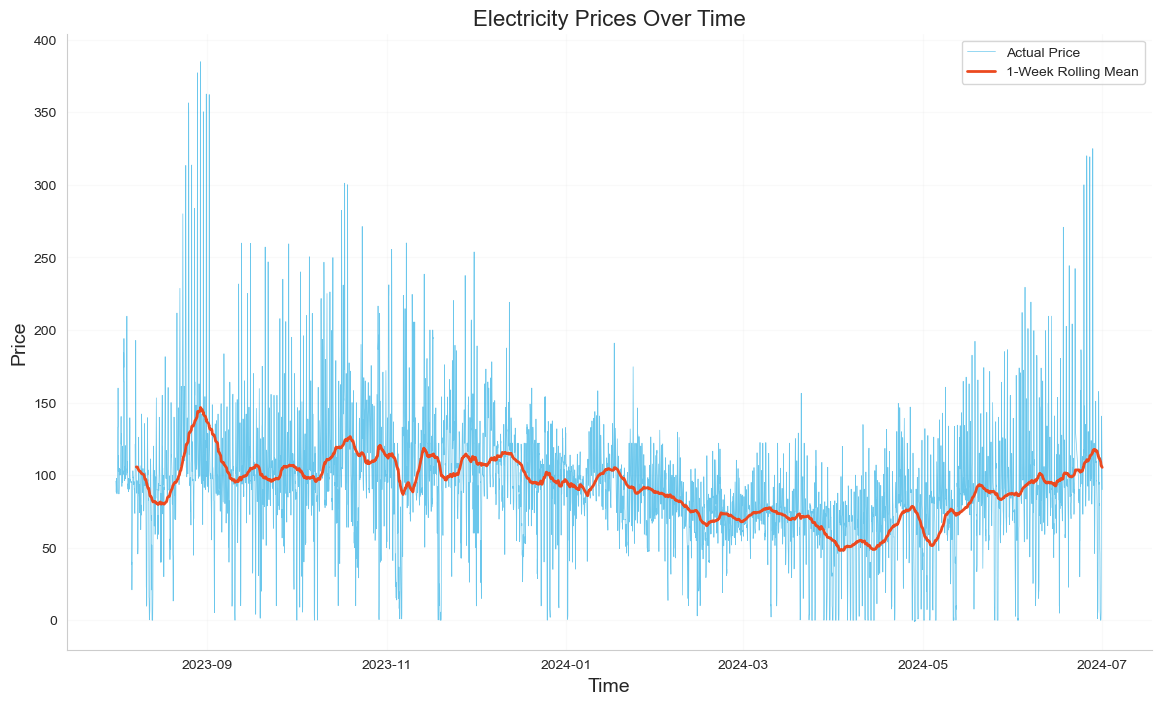

In [14]:
# Rename the price column
actuals.rename(columns={'price': 'Actual_price'}, inplace=True)

# Calculate the rolling mean with a larger window
actuals['Rolling_Mean'] = actuals['Actual_price'].rolling(window=168).mean()  # 168 hours = 1 week

# Plot the actual prices over time with enhancements
plt.figure(figsize=(14, 8))
plt.plot(actuals['datetime_from'], actuals['Actual_price'], color=palette['light_blue'], label='Actual Price', linewidth=0.5, alpha=0.6)
plt.plot(actuals['datetime_from'], actuals['Rolling_Mean'], color=palette['red'], label='1-Week Rolling Mean', linewidth=2)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Electricity Prices Over Time', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.1)
sns.despine()  # Remove top and right spines for a cleaner look
plt.show()

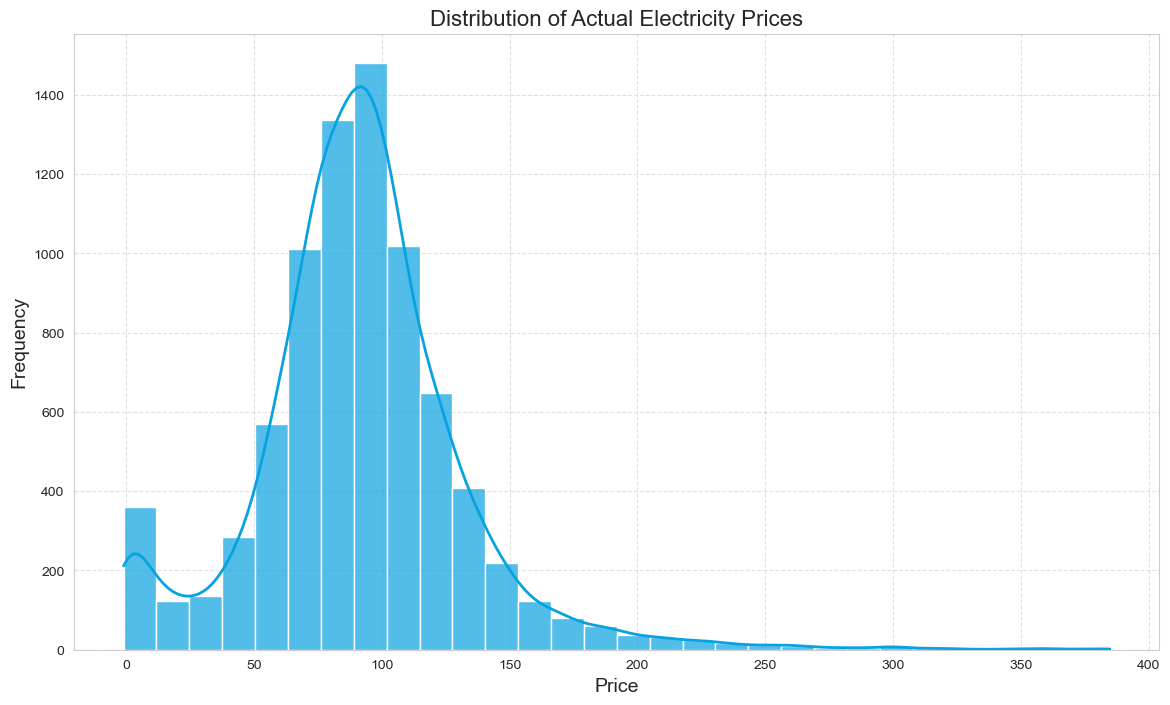

In [15]:
# Rename the price column
actuals.rename(columns={'price': 'Actual_price'}, inplace=True)

# Plot the distribution of actual prices with KDE
plt.figure(figsize=(14, 8))
sns.histplot(actuals['Actual_price'], bins=30, kde=True, color=palette['light_blue'], alpha=0.7, line_kws={'linewidth': 2})
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Actual Electricity Prices', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

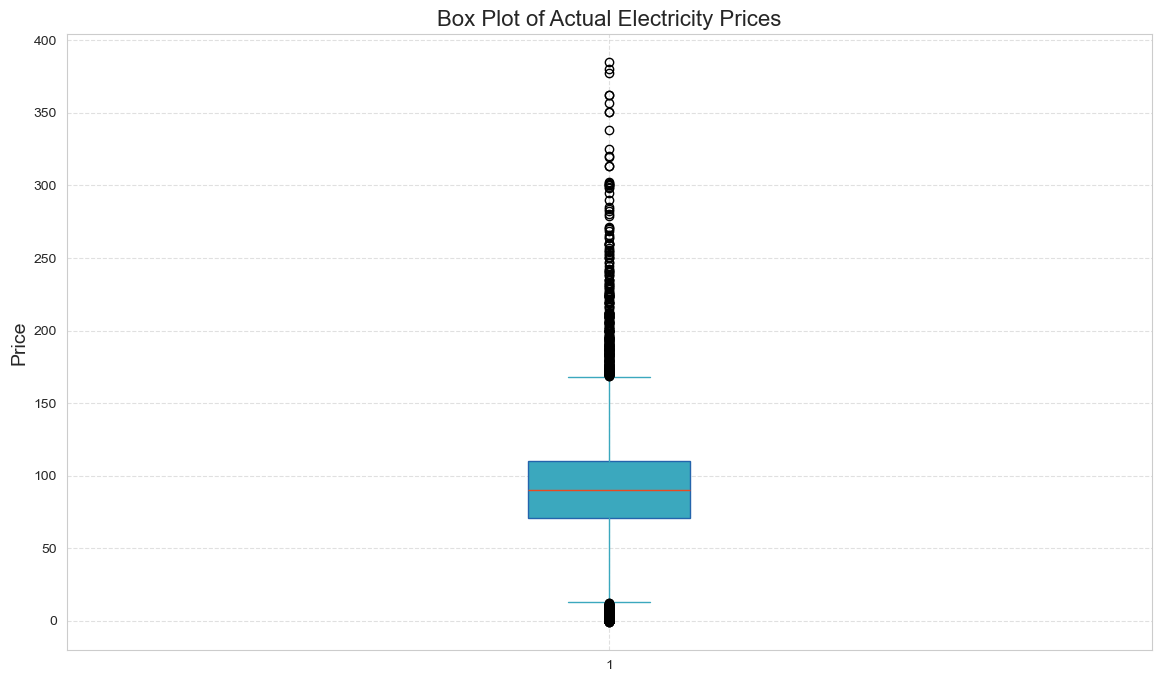

In [16]:
# Box plot of actual prices
plt.figure(figsize=(14, 8))
plt.boxplot(actuals['Actual_price'], patch_artist=True, 
            boxprops=dict(facecolor=palette['teal'], color=palette['medium_blue']),
            whiskerprops=dict(color=palette['teal']),
            capprops=dict(color=palette['teal']),
            medianprops=dict(color=palette['red']))
plt.ylabel('Price', fontsize=14)
plt.title('Box Plot of Actual Electricity Prices', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

C:\Users\Kostas\AppData\Local\Temp\ipykernel_66684\2952155241.py:2: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



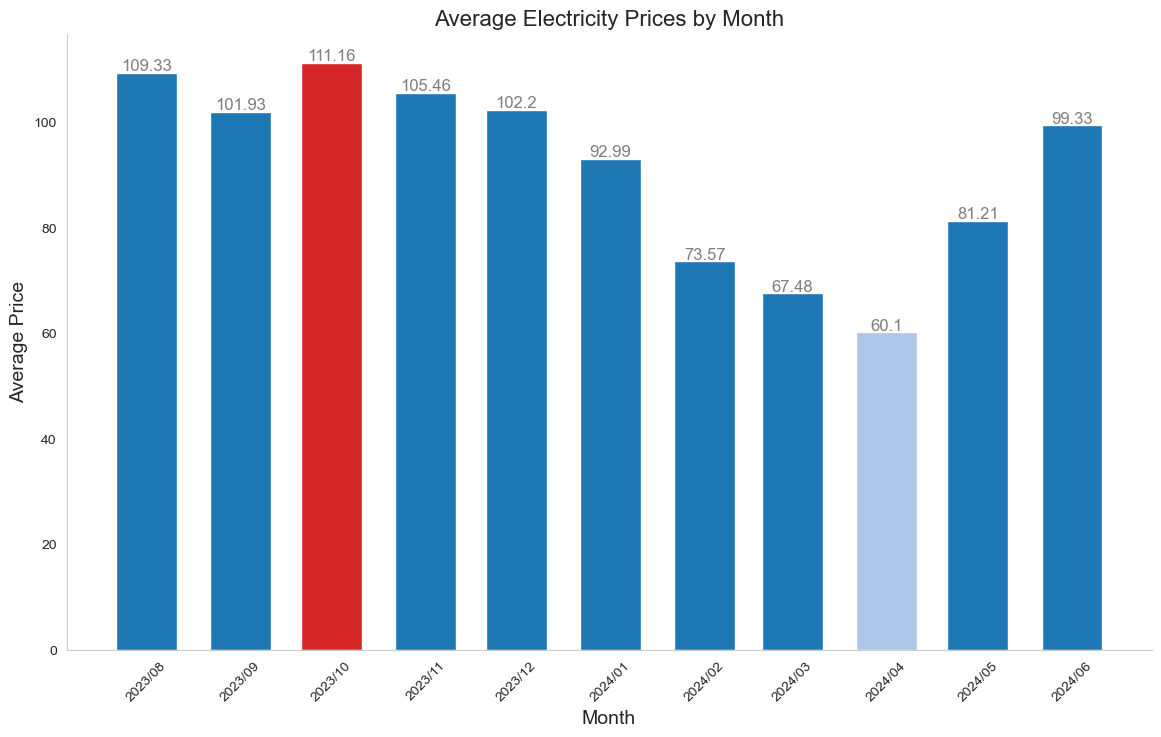

In [20]:

# Calculate average prices by month
monthly_avg_prices = actuals.groupby(actuals['datetime_from'].dt.to_period('M'))['Actual_price'].mean()
monthly_avg_prices.index = monthly_avg_prices.index.to_timestamp()  # Convert period index to timestamp for plotting

# Identify the max and min values
max_value = monthly_avg_prices.max()
min_value = monthly_avg_prices.min()

palette = {
    'dark_blue': '#1f77b4',
    'red': '#d62728',
    'light_blue': '#aec7e8',
    'dark_gray': '#7f7f7f'
}

bar_colors = [palette['dark_blue'] if (value != max_value and value != min_value) 
              else (palette['red'] if value == max_value else palette['light_blue']) 
              for value in monthly_avg_prices.values]

plt.figure(figsize=(14, 8))
bars = plt.bar(monthly_avg_prices.index, monthly_avg_prices.values, color=bar_colors, width=20)  # Increase the width of the bars

# Add value annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', fontsize=12, color=palette['dark_gray'])

plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.title('Average Electricity Prices by Month', fontsize=16)
plt.ylim(bottom=0)  # Set y-axis to start from zero

# Convert x-axis labels to 'YYYY/MM' format
plt.xticks(monthly_avg_prices.index, [date.strftime('%Y/%m') for date in monthly_avg_prices.index], rotation=45)  # Ensure all months are displayed and rotated for better readability

plt.grid(False)  # Disable the grid
sns.despine()  # Remove top and right spines for a cleaner look
plt.show()


C:\Users\Kostas\AppData\Local\Temp\ipykernel_66684\1738066944.py:9: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



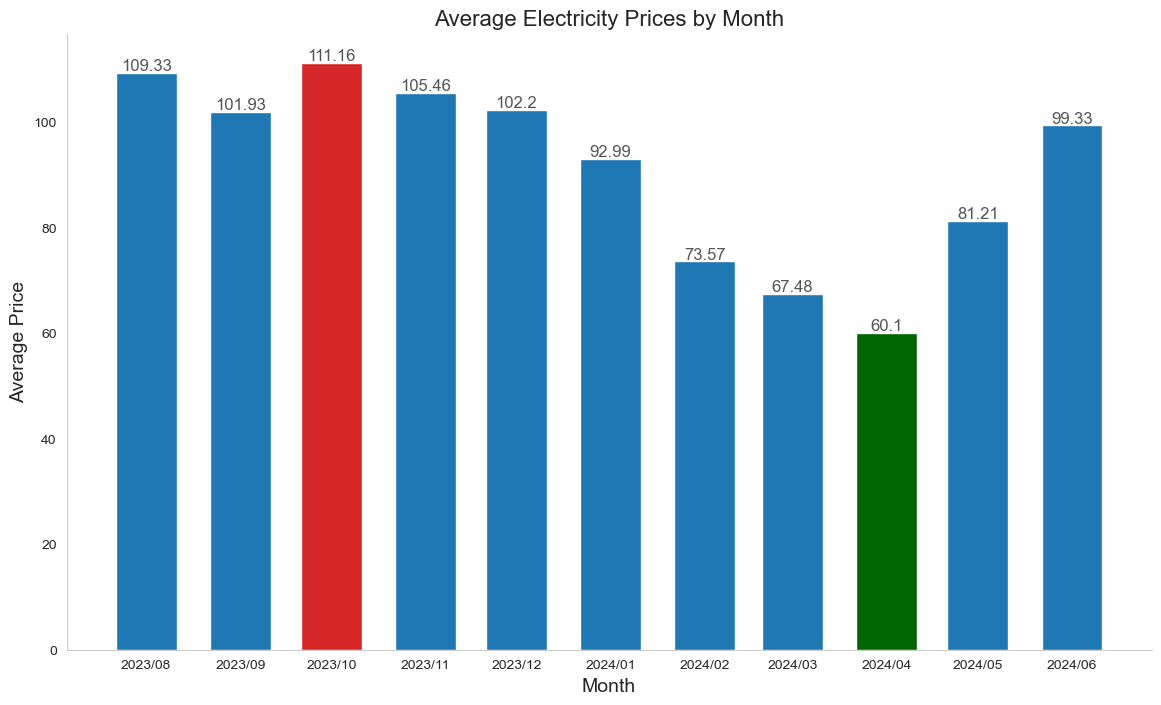

In [23]:
palette = {
    'dark_blue': '#1f77b4',
    'red': '#d62728',
    'dark_green': '#006400',
    'dark_gray': '#555555'
}

# Calculate average prices by month
monthly_avg_prices = actuals.groupby(actuals['datetime_from'].dt.to_period('M'))['Actual_price'].mean()
monthly_avg_prices.index = monthly_avg_prices.index.to_timestamp()  # Convert period index to timestamp for plotting

# Identify the max and min values
max_value = monthly_avg_prices.max()
min_value = monthly_avg_prices.min()

bar_colors = [palette['dark_blue'] if (value != max_value and value != min_value) 
              else (palette['red'] if value == max_value else palette['dark_green']) 
              for value in monthly_avg_prices.values]

plt.figure(figsize=(14, 8))
bars = plt.bar(monthly_avg_prices.index, monthly_avg_prices.values, color=bar_colors, width=20)  # Increase the width of the bars

# Add value annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', fontsize=12, color=palette['dark_gray'])

plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.title('Average Electricity Prices by Month', fontsize=16)
plt.ylim(bottom=0)  # Set y-axis to start from zero
plt.xticks(monthly_avg_prices.index, [date.strftime('%Y/%m') for date in monthly_avg_prices.index],rotation=0)  # Ensure all months are displayed and rotated for better readability
plt.grid(False)  # Disable the grid
sns.despine()  # Remove top and right spines for a cleaner look
plt.show()

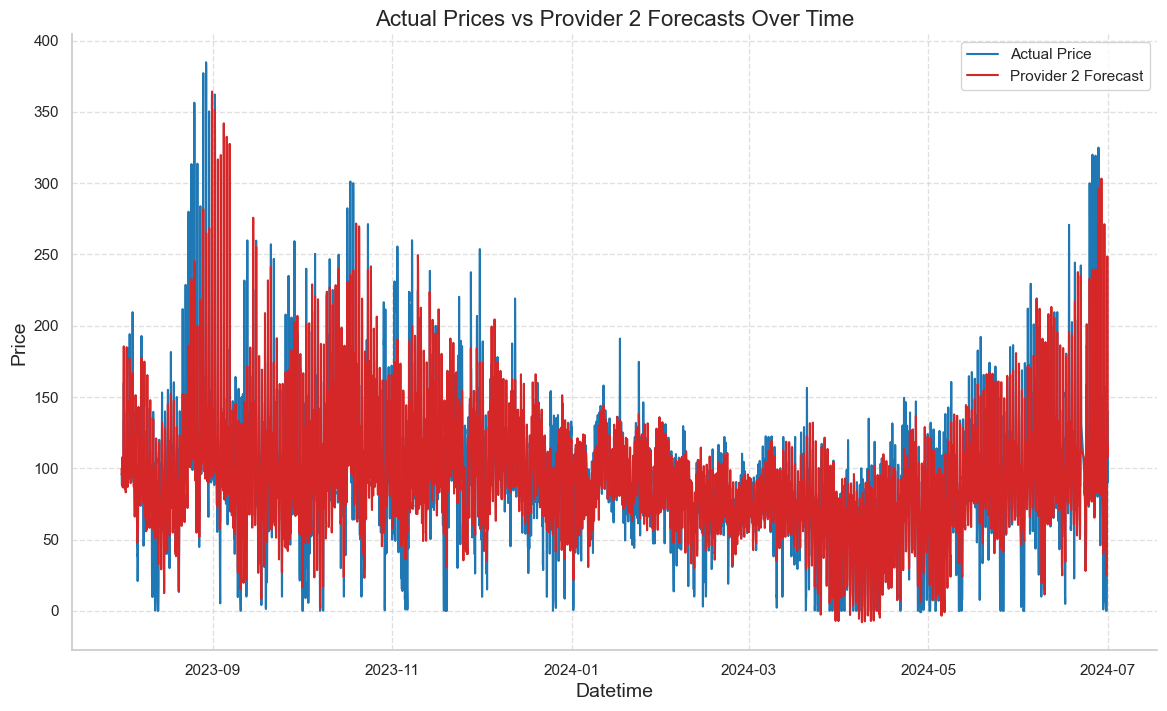

In [18]:
sns.set_theme(style="whitegrid")

comparison_prov2 = actuals.merge(provider2, on='datetime_from')

# Plot actual prices and Provider 2 forecasts over time
plt.figure(figsize=(14, 8))
plt.plot(comparison_prov2['datetime_from'], comparison_prov2['Actual_price'], color=palette['dark_blue'], label='Actual Price')
plt.plot(comparison_prov2['datetime_from'], comparison_prov2['Price_p2'], color=palette['red'], label='Provider 2 Forecast')
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual Prices vs Provider 2 Forecasts Over Time', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()  # Remove top and right spines for a cleaner look
plt.show()

### Holidays & Temperatures Integration 

In [19]:
actuals

,datetime_from,Actual_price,Rolling_Mean
746,2023-08-01 00:00:00+00:00,95.81,NaN
747,2023-08-01 01:00:00+00:00,95.00,NaN
748,2023-08-01 02:00:00+00:00,89.57,NaN
749,2023-08-01 03:00:00+00:00,88.22,NaN
750,2023-08-01 04:00:00+00:00,91.39,NaN
...,...,...,...
8757,2024-06-30 19:00:00+00:00,129.50,105.815119
8758,2024-06-30 20:00:00+00:00,109.08,105.577262
8759,2024-06-30 21:00:00+00:00,102.09,105.522619
8760,2024-06-30 22:00:00+00:00,97.77,105.455655


In [20]:
actuals.drop(columns=['Rolling_Mean'], inplace=True)

In [21]:
from holidays import holidays

# Initialize an empty dictionary for holiday dates
holiday_dict = {}

# Populate the holiday dictionary with dates and Descriptions
for date_str, description in holidays:
    date_obj = datetime.strptime(date_str, '%Y %B %d')
    formatted_date = date_obj.strftime('%Y-%m-%d')
    holiday_dict[formatted_date] = description

In [22]:
for name, df in actuals.items():
    # Check each date in the DataFrame against the holiday dictionary
    actuals['is_holiday'] = actuals['datetime_from'].dt.strftime('%Y-%m-%d').apply(lambda x: 1 if x in holiday_dict else 0)
    print(f"Updated {name} with holiday identification:")
    print(df)
    print("-" * 40)  # Separator for readability

Updated datetime_from with holiday identification:
746    2023-08-01 00:00:00+00:00
747    2023-08-01 01:00:00+00:00
748    2023-08-01 02:00:00+00:00
749    2023-08-01 03:00:00+00:00
750    2023-08-01 04:00:00+00:00
                  ...           
8757   2024-06-30 19:00:00+00:00
8758   2024-06-30 20:00:00+00:00
8759   2024-06-30 21:00:00+00:00
8760   2024-06-30 22:00:00+00:00
8761   2024-06-30 23:00:00+00:00
Name: datetime_from, Length: 8016, dtype: datetime64[ns, UTC]
----------------------------------------
Updated Actual_price with holiday identification:
746      95.81
747      95.00
748      89.57
749      88.22
750      91.39
         ...  
8757    129.50
8758    109.08
8759    102.09
8760     97.77
8761     90.00
Name: Actual_price, Length: 8016, dtype: float64
----------------------------------------


In [23]:
#Check that we have correct days for holidays 
def find_holiday_dates(actuals):
    # Filter rows where 'is_holiday' is 1
    holiday_rows = actuals[actuals['is_holiday'] == 1]

    # Extract just the date part from 'DateTime'
    holiday_dates = holiday_rows['datetime_from'].dt.date

    # Find unique dates
    unique_holiday_dates = pd.unique(holiday_dates)
    return unique_holiday_dates

In [24]:
print(find_holiday_dates(actuals))

[datetime.date(2023, 8, 15) datetime.date(2023, 10, 28)
 datetime.date(2023, 12, 25) datetime.date(2023, 12, 26)
 datetime.date(2024, 1, 1) datetime.date(2024, 1, 6)
 datetime.date(2024, 3, 18) datetime.date(2024, 3, 25)
 datetime.date(2024, 5, 1) datetime.date(2024, 5, 3)
 datetime.date(2024, 5, 5) datetime.date(2024, 5, 6)
 datetime.date(2024, 6, 23) datetime.date(2024, 6, 24)]


In [25]:
actuals

,datetime_from,Actual_price,is_holiday
746,2023-08-01 00:00:00+00:00,95.81,0
747,2023-08-01 01:00:00+00:00,95.00,0
748,2023-08-01 02:00:00+00:00,89.57,0
749,2023-08-01 03:00:00+00:00,88.22,0
750,2023-08-01 04:00:00+00:00,91.39,0
...,...,...,...
8757,2024-06-30 19:00:00+00:00,129.50,0
8758,2024-06-30 20:00:00+00:00,109.08,0
8759,2024-06-30 21:00:00+00:00,102.09,0
8760,2024-06-30 22:00:00+00:00,97.77,0


In [26]:
dft = pd.read_csv('Temperatures.csv')

In [27]:
dft

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Greece,2023-05-31,24.4,15.8,20.2,24.4,15.8,20.2,14.9,72.4,...,12.6,5,NaN,2023-05-31T06:04:55,2023-05-31T20:40:56,0.38,"Rain, Partially cloudy",Becoming cloudy in the afternoon with morning ...,rain,"LGEL,16716199999,F6908,E4115,LGAV,16741099999,..."
1,Greece,2023-06-01,28.5,17.2,22.4,27.4,17.2,22.3,11.5,54.2,...,26.1,9,NaN,2023-06-01T06:04:31,2023-06-01T20:41:37,0.41,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"LGEL,16716199999,F6908,E4115,LGAV,16741099999,..."
2,Greece,2023-06-02,23.5,18.0,20.5,23.5,18.0,20.5,10.6,54.5,...,8.3,3,NaN,2023-06-02T06:04:09,2023-06-02T20:42:17,0.44,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"LGEL,16716199999,E4115,LGAV,16741099999,167180..."
3,Greece,2023-06-03,28.4,14.5,21.7,27.5,14.5,21.5,11.5,57.4,...,22.8,8,NaN,2023-06-03T06:03:48,2023-06-03T20:42:56,0.47,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"LGEL,16716199999,E4115,LGAV,16741099999,167180..."
4,Greece,2023-06-04,27.9,15.3,21.9,27.3,15.3,21.8,11.5,53.7,...,16.6,7,NaN,2023-06-04T06:03:30,2023-06-04T20:43:33,0.50,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"LGEL,16716199999,E0407,E4115,LGAV,16741099999,..."
5,Greece,2023-06-05,27.7,19.2,23.2,27.1,19.2,23.1,10.3,45.9,...,28.0,10,NaN,2023-06-05T06:03:13,2023-06-05T20:44:10,0.54,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"LGEL,16716199999,F6908,E4115,LGAV,16741099999,..."
6,Greece,2023-06-06,27.3,20.6,23.3,26.7,20.6,23.2,9.0,40.7,...,27.7,9,NaN,2023-06-06T06:02:58,2023-06-06T20:44:46,0.58,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"LGEL,16716199999,E4115,LGAV,16741099999,167180..."
7,Greece,2023-06-07,27.3,17.3,22.6,27.1,17.3,22.6,10.7,47.7,...,25.4,8,NaN,2023-06-07T06:02:45,2023-06-07T20:45:20,0.61,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"LGEL,16716199999,F6908,E4115,LGAV,16741099999,..."
8,Greece,2023-06-08,27.3,20.1,23.3,27.1,20.1,23.3,12.0,49.4,...,24.5,8,NaN,2023-06-08T06:02:34,2023-06-08T20:45:53,0.65,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"LGEL,16716199999,E4115,LGAV,16741099999,167180..."
9,Greece,2023-06-09,28.4,17.9,23.6,27.8,17.9,23.5,12.6,51.4,...,24.6,9,NaN,2023-06-09T06:02:24,2023-06-09T20:46:25,0.69,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"LGEL,16716199999,F6908,E4115,LGAV,16741099999,..."


In [28]:
dft['datetime'] = pd.to_datetime(dft['datetime'])

In [29]:
# Ensure the datetime columns are properly parsed and create a date column
actuals['datetime_from'] = pd.to_datetime(actuals['datetime_from'], errors='coerce', utc=True)
actuals['date'] = actuals['datetime_from'].dt.date
dft['date'] = pd.to_datetime(dft['datetime']).dt.date

# Merge the dataframes on the date column
merged_data = pd.merge(actuals, dft[['date', 'temp']], on='date', how='left')
merged_data.drop(columns=['date'], inplace=True)

# Display the first few rows of the merged dataframe
merged_data.head(10)

,datetime_from,Actual_price,is_holiday,temp
0,2023-08-01 00:00:00+00:00,95.81,0,29.1
1,2023-08-01 01:00:00+00:00,95.00,0,29.1
2,2023-08-01 02:00:00+00:00,89.57,0,29.1
3,2023-08-01 03:00:00+00:00,88.22,0,29.1
4,2023-08-01 04:00:00+00:00,91.39,0,29.1
5,2023-08-01 05:00:00+00:00,97.53,0,29.1
6,2023-08-01 06:00:00+00:00,97.86,0,29.1
7,2023-08-01 07:00:00+00:00,91.61,0,29.1
8,2023-08-01 08:00:00+00:00,90.71,0,29.1
9,2023-08-01 09:00:00+00:00,87.10,0,29.1


In [30]:
merged_data.to_csv('actuals_temp_hol.csv')

###  EDA with temp and holidays

In [31]:
df = pd.read_csv('actuals_temp_hol.csv')

In [32]:
df

,Unnamed: 0,datetime_from,Actual_price,is_holiday,temp
0,0,2023-08-01 00:00:00+00:00,95.81,0,29.1
1,1,2023-08-01 01:00:00+00:00,95.00,0,29.1
2,2,2023-08-01 02:00:00+00:00,89.57,0,29.1
3,3,2023-08-01 03:00:00+00:00,88.22,0,29.1
4,4,2023-08-01 04:00:00+00:00,91.39,0,29.1
...,...,...,...,...,...
8011,8011,2024-06-30 19:00:00+00:00,129.50,0,28.6
8012,8012,2024-06-30 20:00:00+00:00,109.08,0,28.6
8013,8013,2024-06-30 21:00:00+00:00,102.09,0,28.6
8014,8014,2024-06-30 22:00:00+00:00,97.77,0,28.6


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8016 entries, 0 to 8015
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     8016 non-null   int64  
 1   datetime_from  8016 non-null   object 
 2   Actual_price   8016 non-null   float64
 3   is_holiday     8016 non-null   int64  
 4   temp           8016 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 313.3+ KB


In [34]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df['datetime_from'] = pd.to_datetime(df['datetime_from'], errors='coerce', utc=True)

# Extract the date part from datetime
df['date'] = df['datetime_from'].dt.date

In [35]:
# Convert event dates to datetime.date format
events = {
    pd.Timestamp('2023-08-15').date(): 'EU gas storage target reached early',
    pd.Timestamp('2023-09-10').date(): 'New EU energy regulations implemented',
    pd.Timestamp('2023-11-20').date(): 'Geopolitical tensions affecting supply',
    pd.Timestamp('2024-02-05').date(): 'Gas supply drop due to infrastructure issues',
    pd.Timestamp('2024-04-18').date(): 'Renewable energy subsidy program introduced'
}

# Add event column to the dataset
df['event'] = df['date'].map(events).fillna('')

# Verify events were added
print(df[df['event'] != ''][['date', 'event']])

            date                                         event
336   2023-08-15           EU gas storage target reached early
337   2023-08-15           EU gas storage target reached early
338   2023-08-15           EU gas storage target reached early
339   2023-08-15           EU gas storage target reached early
340   2023-08-15           EU gas storage target reached early
341   2023-08-15           EU gas storage target reached early
342   2023-08-15           EU gas storage target reached early
343   2023-08-15           EU gas storage target reached early
344   2023-08-15           EU gas storage target reached early
345   2023-08-15           EU gas storage target reached early
346   2023-08-15           EU gas storage target reached early
347   2023-08-15           EU gas storage target reached early
348   2023-08-15           EU gas storage target reached early
349   2023-08-15           EU gas storage target reached early
350   2023-08-15           EU gas storage target reache

In [36]:
# Aggregate data by day, including temperature and holidays
daily_avg_price = df.groupby('date')['Actual_price'].mean().reset_index()
daily_temp = df.groupby('date')['temp'].mean().reset_index()
daily_holiday = df.groupby('date')['is_holiday'].max().reset_index()
events_df = df.groupby('date')['event'].first().reset_index()

# Merge daily data
daily_data = pd.merge(pd.merge(pd.merge(daily_avg_price, daily_temp, on='date'), daily_holiday, on='date'), events_df, on='date')

In [37]:
# Calculate rolling averages
daily_data['price_rolling_avg'] = daily_data['Actual_price'].rolling(window=3).mean()
daily_data['temp_rolling_avg'] = daily_data['temp'].rolling(window=7).mean()

# Verify the columns
print(daily_data.columns)


Index(['date', 'Actual_price', 'temp', 'is_holiday', 'event',
       'price_rolling_avg', 'temp_rolling_avg'],
      dtype='object')


In [38]:
palette = {
    'gray': '#5e6268',
    'light_blue': '#08a2e0',
    'blue_gray': '#74989a',
    'teal': '#3ba8be',
    'red': '#eb491f',
    'light_teal': '#69bed4',
    'dark_gray': '#0c131d',
    'dark_blue': '#244473',
    'medium_blue': '#2464ac',
    'peach': '#eab995'
}

C:\Users\Kostas\anaconda3\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning:

invalid value encountered in sqrt



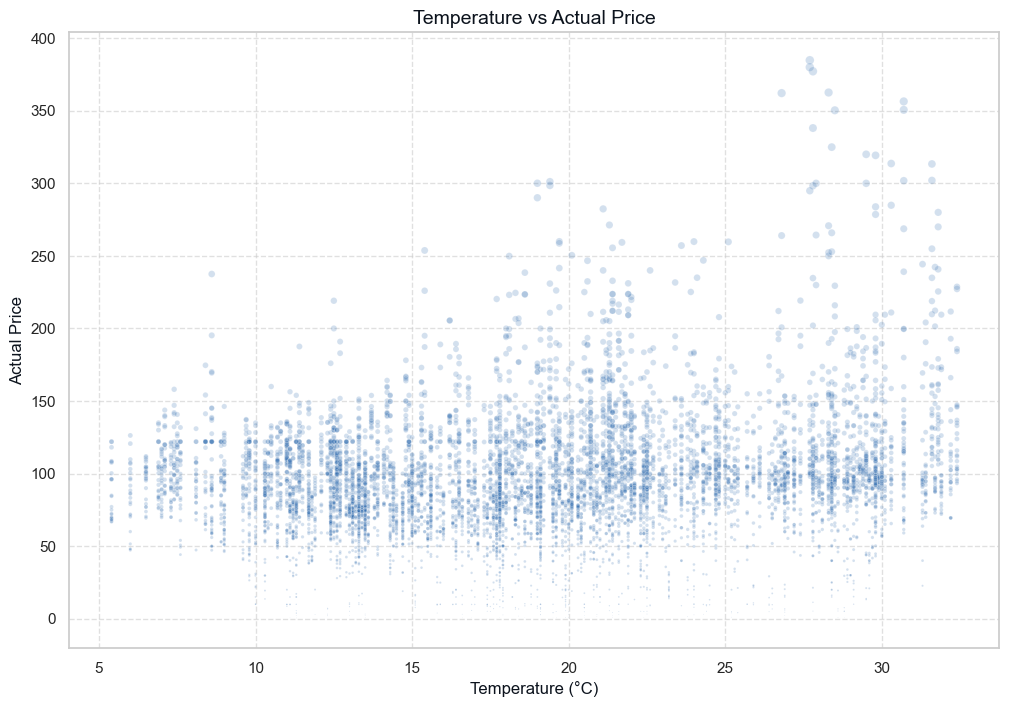

In [39]:
# Bubble Scatter Plot
plt.figure(figsize=(12, 8))
plt.scatter(df['temp'], df['Actual_price'], alpha=0.2, color='#2464ac', s=df['Actual_price']*0.1, edgecolor='w', linewidth=0.5)
plt.title('Temperature vs Actual Price', color='#0c131d', fontsize=14)
plt.xlabel('Temperature (°C)', color='#0c131d', fontsize=12)
plt.ylabel('Actual Price', color='#0c131d', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

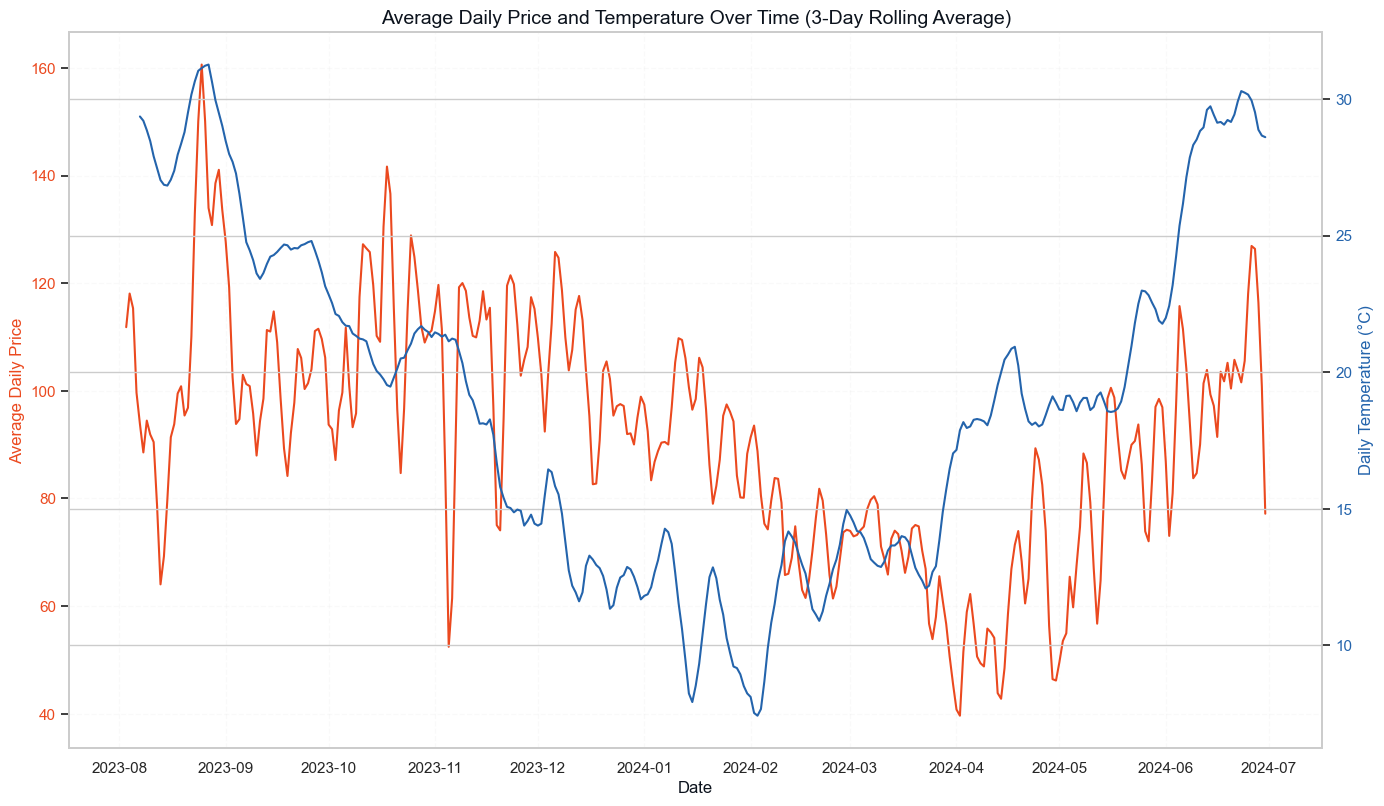

In [40]:
# Line Plot for daily data with secondary y-axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the average daily price
color = '#eb491f'
ax1.set_xlabel('Date', color='#0c131d', fontsize=12)
ax1.set_ylabel('Average Daily Price', color=color, fontsize=12)
ax1.plot(daily_data['date'], daily_data['price_rolling_avg'], color=color, label='Price Rolling Avg (3 days)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.1)

# Plot the daily temperature on a secondary y-axis
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = '#2464ac'
ax2.set_ylabel('Daily Temperature (°C)', color=color, fontsize=12)
ax2.plot(daily_data['date'], daily_data['temp_rolling_avg'], color=color, label='Temp Rolling Avg (3 days)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Average Daily Price and Temperature Over Time (3-Day Rolling Average)', color='#0c131d', fontsize=14)
plt.show()

In [41]:
palette = {
    'gray': '#5e6268',
    'light_blue': '#08a2e0',
    'blue_gray': '#74989a',
    'teal': '#3ba8be',
    'red': '#eb491f',
    'light_teal': '#69bed4',
    'dark_gray': '#0c131d',
    'dark_blue': '#244473',
    'medium_blue': '#2464ac',
    'peach': '#eab995'
}

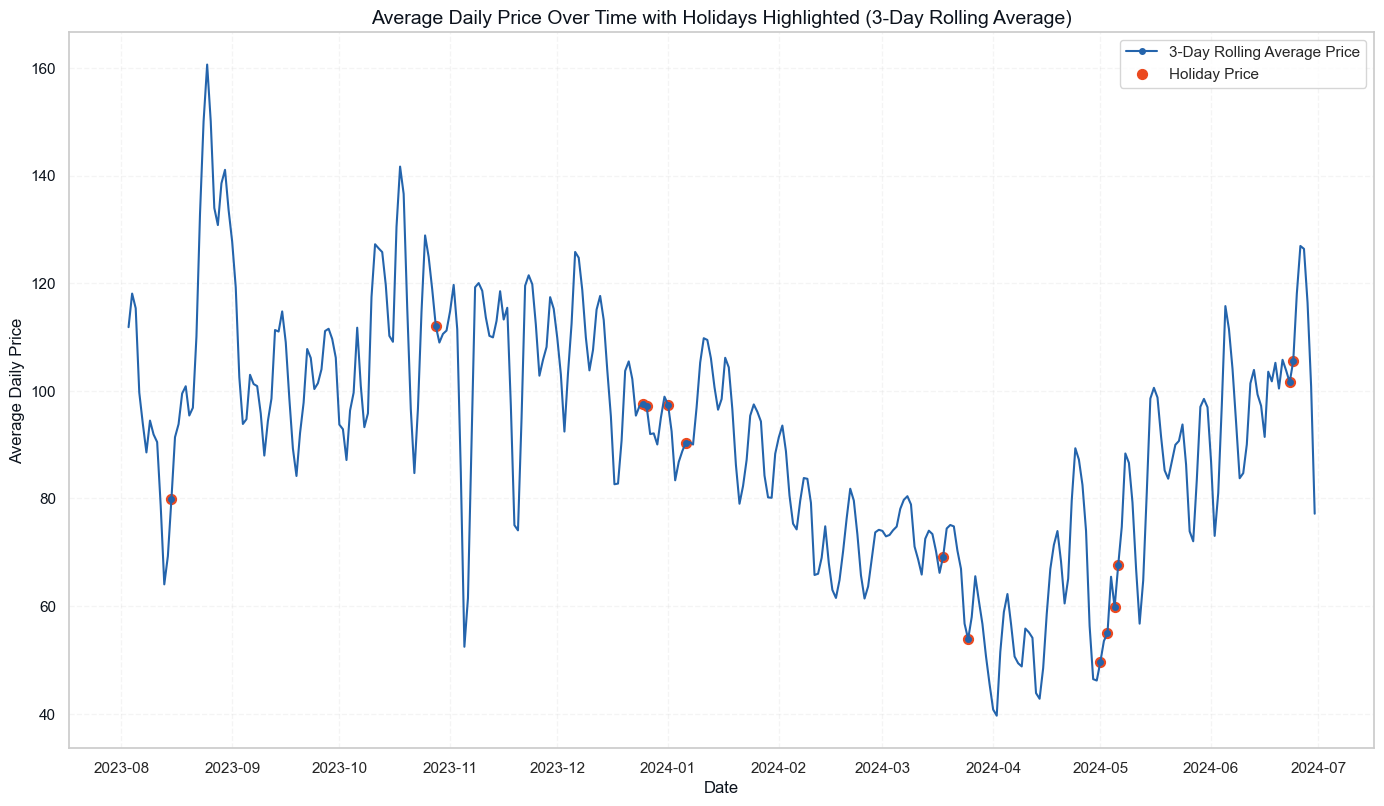

In [42]:
# Line Plot for daily data with holiday markers
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('Date', color='#0c131d', fontsize=12)
ax1.set_ylabel('Average Daily Price', color='#0c131d', fontsize=12)
ax1.plot(daily_data['date'], daily_data['price_rolling_avg'], color='#2464ac', label='3-Day Rolling Average Price', marker='o', markersize=4, markevery=daily_data[daily_data['is_holiday'] == 1].index)
ax1.tick_params(axis='y', labelcolor='#0c131d')
ax1.grid(True, linestyle='--', alpha=0.2)

# Adding holiday markers
ax1.scatter(daily_data[daily_data['is_holiday'] == 1]['date'], daily_data[daily_data['is_holiday'] == 1]['price_rolling_avg'], color='#eb491f', s=50, label='Holiday Price')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Average Daily Price Over Time with Holidays Highlighted (3-Day Rolling Average)', color='#0c131d', fontsize=14)
plt.legend()
plt.show()

### Events

Gas Storage Regulation and Targets:

In August 2023, the EU reached its gas storage target ahead of schedule, filling levels reaching 99% by November 1, 2023. This proactive measure was part of efforts to ensure energy security and stabilize prices amid volatile market conditions​ (Energy)​​ (European Commission)​.

Renewable Energy and Infrastructure:

In April 2024, the EU introduced a substantial subsidy program for renewable energy projects, aiming to accelerate the transition to clean energy. This move was designed to reduce dependency on fossil fuels and stabilize long-term energy prices​ (Energy)​.

Geopolitical Tensions:

Throughout late 2023 and early 2024, geopolitical tensions, particularly those involving major energy suppliers, significantly impacted energy prices. For instance, continued sanctions on Russian energy exports led to shifts in the EU's import patterns and affected overall energy supply stability​ (European Commission).

Economic Policies:

On September 10, 2023, the EU implemented new energy regulations aimed at reducing energy consumption and promoting efficiency. These policies were part of the broader REPowerEU plan to ensure affordable energy prices and secure energy supplies for citizens and businesses​ (Energy)​​ (IEA)​.

Market Fluctuations:

The global economic recovery post-COVID-19, combined with a colder-than-expected winter in the Northern Hemisphere, led to increased demand and subsequently higher energy prices. This period saw the highest gas and coal prices in decades, contributing to the surge in electricity prices across Europe (IEA)


In [52]:
events = {
    '2023-08-15': 'EU gas storage target reached early',
    '2023-09-10': 'New EU energy regulations implemented',
    '2023-11-20': 'Geopolitical tensions affecting supply',
    '2024-02-05': 'Gas supply drop due to infrastructure issues',
    '2024-04-18': 'Renewable energy subsidy program introduced'
}

In [53]:
df.head()

,datetime_from,Actual_price,is_holiday,temp,date,event
0,2023-08-01 00:00:00+00:00,95.81,0,29.1,2023-08-01,
1,2023-08-01 01:00:00+00:00,95.00,0,29.1,2023-08-01,
2,2023-08-01 02:00:00+00:00,89.57,0,29.1,2023-08-01,
3,2023-08-01 03:00:00+00:00,88.22,0,29.1,2023-08-01,
4,2023-08-01 04:00:00+00:00,91.39,0,29.1,2023-08-01,


In [54]:
# Extract the date part from datetime
df['date'] = df['datetime_from'].dt.date

# Add event column to the dataset
df['event'] = df['date'].map(events).fillna('')

# Display the first few rows of the updated dataframe
print(df.head())

              datetime_from  Actual_price  is_holiday  temp        date event
0 2023-08-01 00:00:00+00:00         95.81           0  29.1  2023-08-01      
1 2023-08-01 01:00:00+00:00         95.00           0  29.1  2023-08-01      
2 2023-08-01 02:00:00+00:00         89.57           0  29.1  2023-08-01      
3 2023-08-01 03:00:00+00:00         88.22           0  29.1  2023-08-01      
4 2023-08-01 04:00:00+00:00         91.39           0  29.1  2023-08-01      


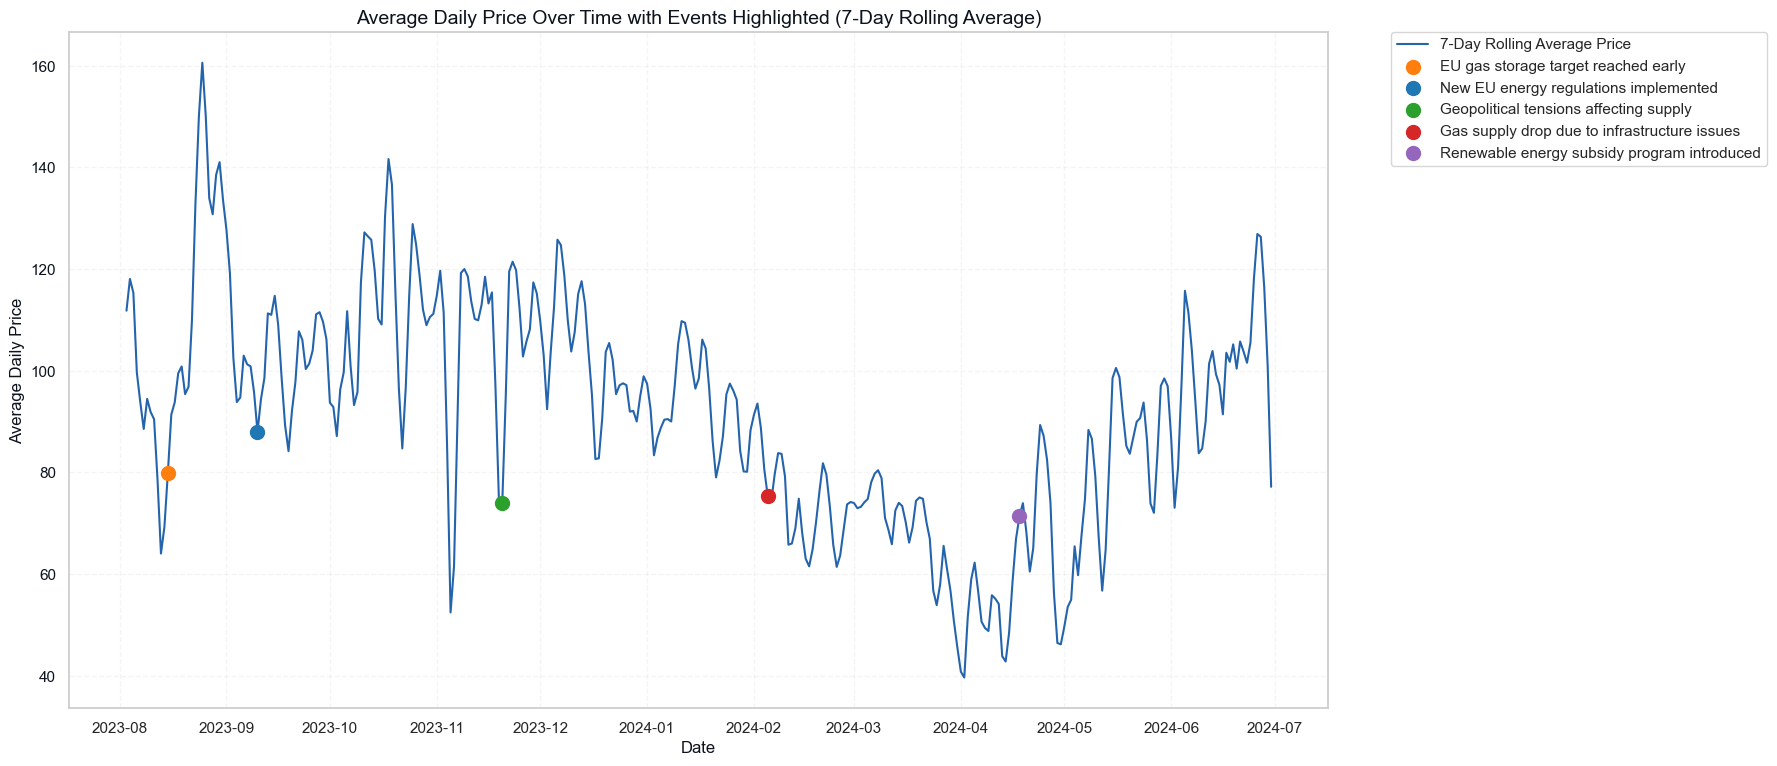

In [56]:
import matplotlib.pyplot as plt

# Define colors for each event
event_colors = {
    'EU gas storage target reached early': '#ff7f0e',
    'New EU energy regulations implemented': '#1f77b4',
    'Geopolitical tensions affecting supply': '#2ca02c',
    'Gas supply drop due to infrastructure issues': '#d62728',
    'Renewable energy subsidy program introduced': '#9467bd'
}

# Line Plot for daily data with event annotations
fig, ax1 = plt.subplots(figsize=(18, 8))  # Increase width for better visibility

# Plot the average daily price
ax1.set_xlabel('Date', color='#0c131d', fontsize=12)
ax1.set_ylabel('Average Daily Price', color='#0c131d', fontsize=12)
ax1.plot(daily_data['date'], daily_data['price_rolling_avg'], color='#2464ac', label='7-Day Rolling Average Price')
ax1.tick_params(axis='y', labelcolor='#0c131d')
ax1.grid(True, linestyle='--', alpha=0.2)

# Adding event markers
for idx, row in daily_data[daily_data['event'] != ''].iterrows():
    event = row['event']
    color = event_colors[event]
    ax1.scatter(row['date'], row['price_rolling_avg'], color=color, s=100, zorder=5, label=event)

# Create a legend with unique labels
handles, labels = ax1.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax1.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjusting the rect parameter to leave space on the sides

plt.title('Average Daily Price Over Time with Events Highlighted (7-Day Rolling Average)', color='#0c131d', fontsize=14)
plt.show()

# Save the plot if necessary
fig.savefig('price_trends_with_events_only_wide.png', bbox_inches='tight')


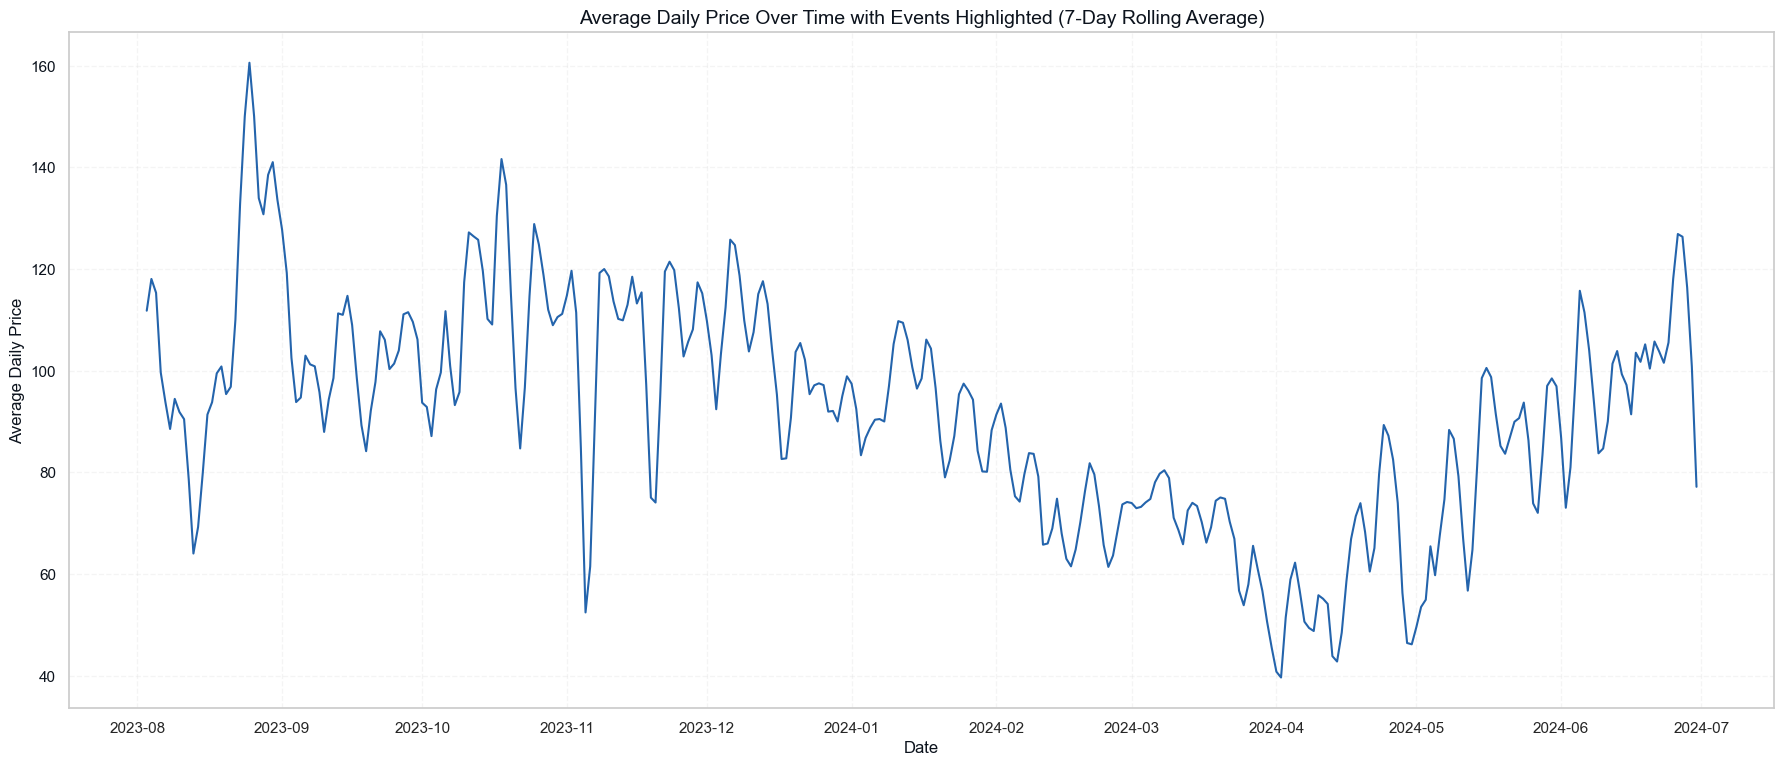

In [58]:
# Define colors for each event
event_colors = {
    'EU gas storage target reached early': '#ff7f0e',
    'New EU energy regulations implemented': '#1f77b4',
    'Geopolitical tensions affecting supply': '#2ca02c',
    'Gas supply drop due to infrastructure issues': '#d62728',
    'Renewable energy subsidy program introduced': '#9467bd'
}

# Line Plot for daily data with event annotations
fig, ax1 = plt.subplots(figsize=(18, 8))  # Increase width for better visibility

# Plot the average daily price
ax1.set_xlabel('Date', color='#0c131d', fontsize=12)
ax1.set_ylabel('Average Daily Price', color='#0c131d', fontsize=12)
ax1.plot(daily_data['date'], daily_data['price_rolling_avg'], color='#2464ac', label='7-Day Rolling Average Price')
ax1.tick_params(axis='y', labelcolor='#0c131d')
ax1.grid(True, linestyle='--', alpha=0.2)

# # Adding event markers
# for idx, row in daily_data[daily_data['event'] != ''].iterrows():
#     event = row['event']
#     color = event_colors[event]
#     ax1.scatter(row['date'], row['price_rolling_avg'], color=color, s=100, zorder=5, label=event)

# Create a legend with unique labels
handles, labels = ax1.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjusting the rect parameter to leave space on the sides

plt.title('Average Daily Price Over Time with Events Highlighted (7-Day Rolling Average)', color='#0c131d', fontsize=14)
plt.show()

# Save the plot if necessary
fig.savefig('price_trends_with_events_only_wide.png', bbox_inches='tight')

In [ ]:
# Create a dictionary to map the events
events_dict = {
    '2023-08-15': 'EU gas storage target reached early',
    '2023-09-10': 'New EU energy regulations implemented',
    '2023-11-20': 'Geopolitical tensions affecting supply',
    '2024-02-05': 'Gas supply drop due to infrastructure issues',
    '2024-04-18': 'Renewable energy subsidy program introduced'
}

# Convert the 'date' column to string format to match the dictionary keys
events_df['date'] = events_df['date'].astype(str)

# Map these events to the 'event' column based on the 'date' column
events_df['event'] = events_df['date'].map(events_dict)

# Filter out NaN values
events_filtered = events_df.dropna(subset=['event'])

# Plotting the count plot of the 'event' column with seaborn's default color
fig, ax = plt.subplots(figsize=(10, 6))

# Use sns.histplot for a default color histogram
sns.histplot(events_filtered['event'], bins=len(events_dict), kde=False, ax=ax)

ax.set_title('Events Categorical Variable')
ax.set_xlabel('Event')
ax.set_ylabel('Frequency')
ax.grid(False)  # Remove grid
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
sns.despine()
plt.show()
